<a href="https://colab.research.google.com/github/kunwar-ajay/Fake-News-Detector/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# run this cell first
!pip install -q datasets scikit-learn nltk pandas matplotlib seaborn

import os, re, string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

# NLTK setup (first time in colab this will download)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
# Example: public repo raw CSVs (change URLs if you prefer)
fake_url  = "https://raw.githubusercontent.com/Reinforz/Fake-News-detection-with-ISOT-Dataset/main/Fake.csv"
true_url  = "https://raw.githubusercontent.com/Reinforz/Fake-News-detection-with-ISOT-Dataset/main/True.csv"

fake = pd.read_csv(fake_url)
true = pd.read_csv(true_url)

# many repos name columns differently; standardize:
fake['label'] = 'fake'
true['label'] = 'real'

# prefer using the 'text' column (if available); fallback to 'title' + 'text'
def pick_text(df):
    if 'text' in df.columns:
        return df['text'].fillna('')
    elif 'content' in df.columns:
        return df['content'].fillna('')
    else:
        # combine title + other cols
        cols = [c for c in df.columns if c.lower() in ('title','headline','body')]
        if cols:
            return df[cols].fillna('').agg(' '.join, axis=1)
        else:
            return df.iloc[:,0].astype(str)

fake_text = pick_text(fake)
true_text = pick_text(true)

df = pd.concat([
    pd.DataFrame({'text': fake_text, 'label': 'fake'}),
    pd.DataFrame({'text': true_text, 'label': 'real'})
], ignore_index=True)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.shape, df.label.value_counts()


((44898, 2),
 label
 fake    23481
 real    21417
 Name: count, dtype: int64)

In [9]:
# basic checks
print(df.shape)
print(df['label'].value_counts())
df['text_length'] = df['text'].str.len()
df['text_length'].describe()


(44898, 2)
label
fake    23481
real    21417
Name: count, dtype: int64


,text_length
count,44898.000000
mean,2469.109693
std,2171.617091
min,1.000000
25%,1234.000000
50%,2186.000000
75%,3105.000000
max,51794.000000


In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 1. lower
    text = text.lower()
    # 2. remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # 3. remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # 4. remove punctuation & numbers (keep letters and spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # 5. tokenize & remove short tokens & stopwords & lemmatize
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

# Apply to a small subset first to estimate time
# df['clean'] = df['text'].apply(clean_text)  # full dataset may take time


In [12]:
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:
# If dataset is large, you can use .progress_apply with tqdm for feedback
from tqdm import tqdm
tqdm.pandas()

df['clean'] = df['text'].progress_apply(clean_text)


100%|██████████| 44898/44898 [02:45<00:00, 271.87it/s]


In [15]:
X = df['clean'].values
y = (df['label'] == 'fake').astype(int).values  # fake=1, real=0

tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)
print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (44898, 30000)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)


(35918, 30000) (8980, 30000)


In [17]:
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=4))


LR Accuracy: 0.9866369710467706
              precision    recall  f1-score   support

           0     0.9813    0.9909    0.9861      4284
           1     0.9916    0.9828    0.9872      4696

    accuracy                         0.9866      8980
   macro avg     0.9864    0.9868    0.9866      8980
weighted avg     0.9867    0.9866    0.9866      8980



In [18]:
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=4))


RF Accuracy: 0.9975501113585746
              precision    recall  f1-score   support

           0     0.9963    0.9986    0.9974      4284
           1     0.9987    0.9966    0.9977      4696

    accuracy                         0.9976      8980
   macro avg     0.9975    0.9976    0.9975      8980
weighted avg     0.9976    0.9976    0.9976      8980



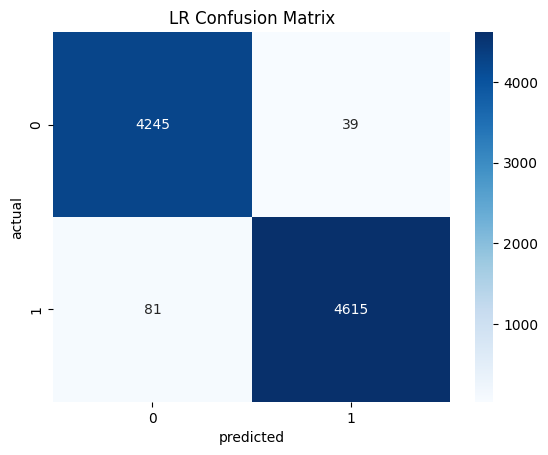

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted'); plt.ylabel('actual'); plt.title('LR Confusion Matrix')
plt.show()


In [20]:
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

# Downloadable in Colab UI or save to Google Drive


In [30]:
def predict_text(text, model=lr, vectorizer=tfidf, threshold=0.6):
    c = clean_text(text)
    v = vectorizer.transform([c])

    # raw model prediction
    proba = model.predict_proba(v)[0]  # [prob_real, prob_fake]
    prob_fake = float(proba[1])
    prob_real = float(proba[0])

    # check threshold
    if prob_fake <= threshold:
        return ("real", prob_real)
    else:
        return ("fake", prob_fake)


In [31]:
print(predict_text("The Prime Minister met with state officials today to review ongoing infrastructure projects."))

('real', 0.5205964903680118)


In [32]:
print(predict_text("The health ministry reported a steady decline in flu cases across the country this week."))

('real', 0.40726483384829004)


In [33]:
print(predict_text("The national railway service added two new trains to improve connectivity between major cities"))

('fake', 0.6256873285421687)


In [34]:
print(predict_text("scientists discovered a miracle "))

('fake', 0.8828901505522666)
